# Optimization algorithms on linear regression
This notebook includes implementation of the following optimization algorithms -
1) Simple Gradient Descent
2) Momentum
3) Nesterov Accelerated Gradient (NAG)
4) Adaptive Gradient (AdaGrad)
5) Root Mean Squared Propagation (RMSprop)
6) Adaptive Moment Estimation (Adam)

The program allows these to be combined with-<br>
--> Batch Gradient Descent<br>
--> Mini-batch GD<br>
--> Stochastic GD<br>
(with learning rate decay)<br>

Here it is applied to a simple linear regression problem. (The linear regression class allows regularised higher degree polynomials with any given number of features, but then plotting would not be possible)

***All of these are scratch implementations .

WHAT ARE THESE ALGORITHMS DOING?
--> They are simply trying to reach the global minima of a function as fast as possible. The function in this case is the cost function for linear regression, but it can be any other function.
What is linear regression and how its cost is calculated is not strictly necessary to understand these optimization techniques.

In [1]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import matplotlib.image as img
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
import os
import numpy as np
import pandas as pd
import math
import time

## Load a sample dataset

In [2]:
df = pd.read_csv('data/insurance.csv')
X_raw = np.array(df["bmi"]).reshape((len(df["bmi"]), 1))
y_raw = np.array(df["charges"])
print(f"Shape: {X_raw.shape}")
print(f"Shape: {y_raw.shape}")

Shape: (1338, 1)
Shape: (1338,)


In [3]:
def plot(X, y, size=4):
    plt.scatter(X, y, s=size)

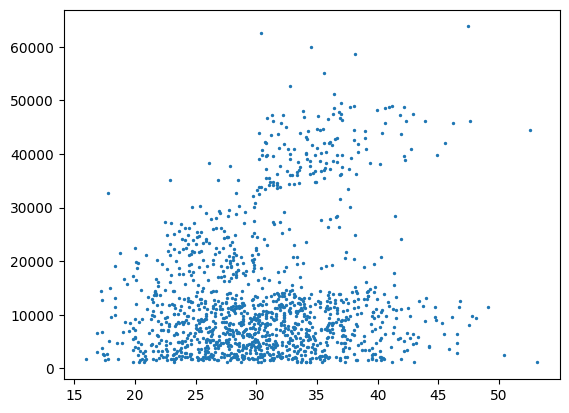

In [4]:
plot(X_raw, y_raw, 2)

## Linear regression (with regularization)

In [5]:
class Model:
    def __init__(self, X_raw, y_raw, degree, ratio, batch_size):
        '''
        parameters: 
            X (m,n) matrix --> m: examples n: features
            y (m,) vector --> m:examples
            degree (integer) --> degree of the intended polynomial
            ratio (tuple/list) --> ratio (train_set:cv_set:test_set)
            batch_size (int) --> number of examples in one mini-batch
                                if batch_size=-1: batch gradient descent will be implemented 
        return:
            X_norm (m,n) matrix --> matrix with normalized data
            self.y (m,) vector --> target values 
            mean (n,) vector --> mean of each feature
            std (n,) vector --> standard deviation of each feature
        '''
        self.X_raw = X_raw
        self.y_raw = y_raw   
        self.X_train, self.y, self.X_cv, self.y_cv, self.X_test, self.y_test = self.split_data(X_raw, y_raw, ratio)
        self.degree = degree
        self.X = self.add_higher_features(degree, self.X_train)
        if batch_size == -1:
            self.batch_size = len(self.X)
        else:
            self.batch_size = batch_size
        self.batches = self.create_batches()
        self.model_trained = False

    def split_data(self, X, y, ratio):
        '''
        parameters: 
            X matrix: the raw data matrix
            y vector: raw target variable vector
            ratio: ratio in which to split X eg. [60, 20, 20] (must add up to 100)
        returns:
            X_train
            y_train
            X_cv
            y_cv
            X_train
            y_train
        '''
        m = X.shape[0]
        randix = np.random.permutation(m)
        
        m_cv = (m*ratio[1])//100
        m_test = (m*ratio[2])//100
    
        at_index = 0
    
        X_cv = X[randix[0: m_cv]]
        y_cv = y[randix[0: m_cv]]
        X_test = X[randix[m_cv: m_test+m_cv]]
        y_test = y[randix[m_cv: m_test+m_cv]]
        X_train = X[randix[m_test+m_cv: ]]
        y_train = y[randix[m_test+m_cv: ]]

        print(f"Shape of X_train: {X_train.shape}")
        print(f"Shape of X_cv: {X_cv.shape}")
        print(f"Shape of X_test: {X_test.shape}")
    
        return X_train, y_train, X_cv, y_cv, X_test, y_test 

    def add_higher_features(self, degree, X_raw):
        '''
        parameters:
            degree (integer): degree of the intended polynomial
            X_raw (m,n) matrix: raw data matrix without added higher degree features
        return:
            X (m,n_new) matrix: data matrix with added higher features
        '''
        features_num = X_raw.shape[1] # Number of features in the raw dataset
        # String creation for execution
        all_var = "("
        rem_str = ""
        for i in range(1, features_num+1):
            range_str = "range"+f"({degree+1})"
            var_str = 'x'+str(i)
            all_var += var_str+','
            rem_str += "for "+var_str+" in "+range_str+" "
        all_var_str = all_var.rstrip(',')+") "
        final_str = f"({all_var_str+rem_str.rstrip()})"
        # String creation ends
    
        all_combos = list(eval(final_str))
        
        power_combos = [] # Combination of the powers
        if type(all_combos[0]) == int:
            for i in range(len(all_combos)):
                all_combos[i] = (all_combos[i], )
        for i in all_combos:
            if i != (0,)*features_num:
                if sum(i) <= degree and i not in power_combos:
                    power_combos.append(i)
        #print(power_combos)
        
        features = [X_raw[:,i] for i in range(features_num)]
    
        added_features_list = []
        for i in power_combos:
            to_add = 1
            for j in range(len(i)):
                to_add *= features[j]**i[j]
            added_features_list.append(to_add)
    
        X = np.ndarray(shape=(X_raw.shape[0], len(added_features_list)))
        for i in range(X.shape[1]):
            X[:,i] = added_features_list[i]
        return X

    def create_batches(self):
        m = len(self.X)
        idx = list(np.arange(0, m, self.batch_size))
        idx.append(m)
        batches = []
        for i in range(1, len(idx)):
            batches.append((idx[i-1], idx[i]))
        print(f"No. of batches: {len(batches)}")
        return batches
        
    #Normalize data
    def normalized_data(self, X=False):
        '''
        parameters:
            X (m,n) matrix: data matrix to be normalized (default: False)
        returns:
            X_norm (m,n) matrix: normalized data 
            mean (n,) vector: mean of each feature
            std (n,) vector: standard deviation of each feature
        '''
        if type(X) != np.ndarray:
           X = self.X
            
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_norm = (X-mean)/std
        
        return X_norm, mean, std

    def predict(self, x_i, w, b):
        '''
        parameters:
            x_i (n,) vector: ith example in the training set
                    it may also be a 2-d matrix of all training examples
                    if m training examples are given --> (m,n) matrix
            w (n,) vector: weight parameter for each feature 
            b (float): bias parameter
        return:
            f_x (float): prediction on given x according to w and b
                    may also a vector if multiple training examples (as a matrix) were given
                    if m training examples are given --> (m,) vector
        '''
        if x_i.ndim == 1:
            f_x = np.sum(w*x_i) + b
        elif x_i.ndim == 2:
            f_x = np.sum(w*x_i, axis=1) + b

        return f_x

    def compute_cost(self, w, b, lambda_):
        '''
        paramters:
            w (n,) vector: weight paramters for all n features
            b (float): bias parameter
            lambda_ (float): regularization parameter
        return:
            j (float): total cost over all training examples
        '''
        X_norm, _, _ = self.normalized_data()
        y = self.y
        m = X_norm.shape[0]
        n = X_norm.shape[1]
        J = 0
        reg_term = 0

        f_x = self.predict(X_norm, w, b)
        J = np.sum((f_x-y)**2)
        J = J/(2*m)

        reg_term = np.sum(w**2)
        reg_term = (lambda_/(2*m))*reg_term

        J = J + reg_term
        return J

    def compute_gradient(self, w, b, lambda_, batch):
        '''
        parameters:
            w (n,) vector: weight parameters 
            b (float): bias parameter
            lambda (float): regularization parameter
            batch (tuple): start and end indices of current batch
        return:
            dj_dw (n,): partial derivative of cost with respect to all the n weight paramters
            dj_db (float): partial derivative of cost with respect to the bias parameters
        '''
        X_norm, _, _ = self.normalized_data()
        X_norm = X_norm[batch[0]: batch[1]]
        y = self.y
        y = y[batch[0]: batch[1]]
        m = X_norm.shape[0]
        n = X_norm.shape[1]

        dj_dw, dj_db = np.zeros(n), 0

        error = self.predict(X_norm, w, b) - y
        dj_dw = np.sum(error*X_norm.transpose(), axis=1)
        dj_db = np.sum(error)
        dj_dw = (dj_dw/m) + ((lambda_/m)*w)
        dj_db = dj_db/m

        return dj_dw, dj_db

    def gradient_descent(self, w, b, alpha, lambda_, num_iters, optimizer, hyperparameters, decay_rate, store_hist):
        '''
        parameters:
            w (n,) vector: initial weight parameters
            b (float): initial bias parameter
            alpha (float): learning rate
            lambda_ (float): regularization parameter
            num_iters: number of epochs for gradient descent
                        NOTE: one epoch contains updation over all mini-batches one by one
            optimizer (str): which optimizer is to be used
                            "GD" --> Gradient Descent
                            "Momentum" --> Momentum
                            "NAG" --> Nesterov Accelerated Gradient
                            "AdaGrad" --> Adaptive Gradient
                            "RMSprop" --> Root Mean Squared propagation
                            "Adam" --> Adaptive Moment Estimation
            hyperparameters (list/tuple): hyperparameters according to the optimizer
                            "GD" --> None (default)
                            "Momentum" --> (beta, )
                            "NAG" --> (beta, )
                            "AdaGrad" --> (E, )
                            "RMSprop" --> (beta, E)
                            "Adam" --> (beta1, beta2, E)
                                        beta1: for Momentum part
                                        beta2: for RMSprop part
            decay_rate (float): decay rate for learning rate decay
            store_hist (True/False): whether to store j_hist, w_hist, b_hist or not
        returns:
            w (n,) vector: weigth parameters after gradient descent
            b (float): bias parameter after gradient descent
            j_hist (list): history of cost
            w_hist (dict): history of weight parameters 
            b_hist (dict): history of bias parameters 
        '''
        j_hist = []
        w_hist = []
        b_hist = []
        w_hist.append(w)
        b_hist.append(b)
        j_hist.append(self.compute_cost(w, b, lambda_))
        self.w_hist_small = {}
        self.b_hist_small = {}
        update_steps = 1
        v_w = np.zeros(len(w))
        v_b = 0
        s_w = np.zeros(len(w))
        s_b = 0
        for i in range(1, num_iters+1):
            alpha_ = alpha/(1+(i*decay_rate))
            for batch in self.batches:
                if optimizer=="GD":
                    dj_dw, dj_db = self.compute_gradient(w, b, lambda_, batch)
                    w = w - alpha_*dj_dw
                    b = b - alpha_*dj_db
                elif optimizer=="Momentum":
                    beta = hyperparameters[0]
                    dj_dw, dj_db = self.compute_gradient(w, b, lambda_, batch)
                    v_w = (beta*v_w) + (alpha_*dj_dw)
                    v_b = (beta*v_b) + (alpha_*dj_db)
                    w = w - v_w
                    b = b - v_b
                elif optimizer=="NAG":
                    beta = hyperparameters[0]
                    w_la = w - (beta*v_w)
                    b_la = b - (beta*v_b)
                    dj_dw_la, dj_db_la = self.compute_gradient(w_la, b_la, lambda_, batch)
                    v_w = (beta*v_w) + (alpha_*dj_dw_la)
                    v_b = (beta*v_b) + (alpha_*dj_db_la)
                    w = w - v_w
                    b = b - v_b
                elif optimizer=="AdaGrad":
                    E = hyperparameters[0]
                    dj_dw, dj_db = self.compute_gradient(w, b, lambda_, batch)
                    v_w = v_w + (dj_dw**2)
                    v_b = v_b + (dj_db**2)
                    w = w - ((alpha_/(np.sqrt(v_w)+E))*dj_dw)
                    b = b - ((alpha_/(np.sqrt(v_b)+E))*dj_db)
                elif optimizer=="RMSprop":
                    beta, E = hyperparameters
                    dj_dw, dj_db = self.compute_gradient(w, b, lambda_, batch)
                    s_w = (beta*s_w) + (1-beta)*(dj_dw**2)
                    s_b = (beta*s_b) + (1-beta)*(dj_db**2)
                    w = w - ((alpha_/(np.sqrt(s_w)+E))*dj_dw)
                    b = b - ((alpha_/(np.sqrt(s_b)+E))*dj_db)
                elif optimizer=="Adam":
                    t = update_steps
                    beta1, beta2, E = hyperparameters
                    dj_dw, dj_db = self.compute_gradient(w, b, lambda_, batch)
                    v_w = (beta1*v_w) + (1-beta1)*(dj_dw)
                    v_b = (beta1*v_b) + (1-beta1)*(dj_db)
                    s_w = (beta2*s_w) + (1-beta2)*(dj_dw**2)
                    s_b = (beta2*s_b) + (1-beta2)*(dj_db**2)
                    v_w_c = v_w/(1-(beta1**t))
                    v_b_c = v_b/(1-(beta1**t))
                    s_w_c = s_w/(1-(beta2**t))
                    s_b_c = s_b/(1-(beta2**t))
                    w = w - ((alpha_/(np.sqrt(s_w_c)+E))*v_w_c)
                    b = b - ((alpha_/(np.sqrt(s_b_c)+E))*v_b_c)
                    #print((((alpha/(np.sqrt(s_w)+E))*v_w), ((alpha/(np.sqrt(s_b)+E))*v_b))) 
                if store_hist:
                    j = self.compute_cost(w, b, lambda_) # Compute j on each iteration only when storing is required
                if update_steps% math.ceil(num_iters*len(self.batches)/10) == 0 or update_steps == (num_iters*len(self.batches)-1):
                    # Prints the model status 10 times in total
                    if not store_hist:
                        j = self.compute_cost(w, b, lambda_)
                    self.w_hist_small[i] = w
                    self.b_hist_small[i] = b
                    print(f"At epoch: {str(i)}| At updation step: {str(update_steps)}")
                    print(f"\t j: {str(j)}")
                    print(f"\t w: {str(w)}")
                    print(f"\t b: {str(b)}")
    
                if store_hist:
                    if i<=100000:
                        j_hist.append(j)
                        w_hist.append(w)
                        b_hist.append(b)
                update_steps += 1
        return w, b, j_hist, w_hist, b_hist
    def fit(self, alpha, lambda_, num_iters, optimizer, hyperparameters=None, decay_rate=0.0, store_hist=True, compute_test_error=False, w=False, b=0):
        '''
        parametes:
            alpha (float): learning rate
            lambda_ (float): regularization parameter
            num_iters (int): number of iterations for gradient descent 
            optimizer (str): which optimizer is to be used
                            "GD" --> Gradient Descent
                            "Momentum" --> Momentum
                            "NAG" --> Nesterov Accelerated Gradient
                            "AdaGrad" --> Adaptive Gradient
                            "RMSprop" --> Root Mean Squared propagation
                            "Adam" --> Adaptive Moment Estimation
            hyperparameters (list/tuple): hyperparameters according to the optimizer
                            "GD" --> None (default)
                            "Momentum" --> (beta, )
                            "NAG" --> (beta, )
                            "AdaGrad" --> (E, )
                            "RMSprop" --> (beta, E)
                            "Adam" --> (beta1, beta2)
                                        beta1: for Momentum part
                                        beta2: for RMSprop part
            decay_rate (float): decay rate for learning rate decay
                                Default: 0.0
            store_hist (True/False): whether to store j_hist, w_hist, b_hist or not
            compute_test_error (True/False): whether to compute test error or not
            w (n,) vector: initial weight parameters 
            b (float): initial bias parameter
        return:
            None
        '''
        _, self.mean, self.std = self.normalized_data()

        if type(w) != np.ndarray:
            w = np.zeros(self.X.shape[1])

        start_time = time.time()
        self.w, self.b, self.j_hist, self.w_hist, self.b_hist = self.gradient_descent(w, b, alpha, lambda_, num_iters,
                                                                                      optimizer, hyperparameters, decay_rate, store_hist)
        end_time = time.time()
        self.training_time = end_time-start_time
        
        self.model_trained = True

        print(f"Training time: {self.training_time}")
        self.training_error = self.compute_error(self.X_train, self.y)
        print(f"Training Error (J_train): {self.training_error}")
        self.cv_error = self.compute_error(self.X_cv, self.y_cv)
        print(f"Cross Validation Error (J_cv): {self.cv_error}")

        if compute_test_error:
            self.test_error = self.compute_error(self.X_test, self.y_test)
            print(f"Test Error (J_test): {self.test_error}")
            

    def new_prediction(self, x_i, use_trained_val=True, w=None, b=None):
        '''
        parameters:
            x_i (ndarray/ list/ tuple): a single example or multiple examples as a matrix
            use_trained_val: True if the final trained values are to be used for prediction
            w (n,) vector: weights if the final trained weights are not to be used
            b (float): bias if the final trained bias is not to be used
        return:
            prediction (int/float/none): model's predicition on x_i
        '''
        if self.model_trained:
            if type(x_i) == np.ndarray and x_i.ndim == 1:
                x_i = x_i.reshape((1, self.X_raw.shape[1]))
            elif type(x_i) == list or type(x_i) == tuple:
                x_i = np.array([x_i])
            x_i_modified = (self.add_higher_features(self.degree, x_i)-self.mean)/self.std
            if use_trained_val:
                prediction = self.predict(x_i_modified, self.w, self.b)
            else:
                prediction = self.predict(x_i_modified, w, b)
            return prediction
            
        else:
            print("Train the model first")
            return None

    def compute_error(self, X, y):
        if self.model_trained:
            m = X.shape[0]
            J = 0
            f_x = self.new_prediction(X)
            J = np.sum((f_x-y)**2)
            J = J/(2*m)
            return J
        else:
            print("Train the model first")

# Batch Gradient descent
### model_1

In [6]:
model_1 = Model(X_raw, y_raw, 1, [80, 20, 0], -1)

Shape of X_train: (1071, 1)
Shape of X_cv: (267, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [7]:
model_1.fit(alpha=0.1, lambda_=0, num_iters=170,
            optimizer="GD", store_hist=True, compute_test_error=False)

At epoch: 17| At updation step: 17
	 j: 73937345.19223884
	 w: [1982.35018015]
	 b: 11132.651515967875
At epoch: 34| At updation step: 34
	 j: 71447392.08541527
	 w: [2312.95032162]
	 b: 12989.264037276522
At epoch: 51| At updation step: 51
	 j: 71378139.42067616
	 w: [2368.08510791]
	 b: 13298.894680913927
At epoch: 68| At updation step: 68
	 j: 71376213.30746531
	 w: [2377.2800364]
	 b: 13350.532345951184
At epoch: 85| At updation step: 85
	 j: 71376159.73678878
	 w: [2378.81349133]
	 b: 13359.144053174912
At epoch: 102| At updation step: 102
	 j: 71376158.24683617
	 w: [2379.0692284]
	 b: 13360.580243236056
At epoch: 119| At updation step: 119
	 j: 71376158.20539638
	 w: [2379.11187813]
	 b: 13360.819759262107
At epoch: 136| At updation step: 136
	 j: 71376158.20424381
	 w: [2379.1189909]
	 b: 13360.85970378497
At epoch: 153| At updation step: 153
	 j: 71376158.20421176
	 w: [2379.12017711]
	 b: 13360.866365405627
At epoch: 169| At updation step: 169
	 j: 71376158.20421086
	 w: [237

### Check convergence

In [8]:
def check_convergence(model):
    converged = False
    j_hist = model.j_hist
    for i in range(len(j_hist)):
        if j_hist[i] == j_hist[i-1]:
            print(f"Converged at updation step: {i-1}")
            converged = True
            return i-1
            break
    if not converged:
        print("Convergence: False")
        return False
check_convergence(model_1)

Converged at updation step: 167


167

In [9]:
print(model_1.w)
print(model_1.b)

[2379.12037494]
13360.867476376206


### Plotting the model

In [75]:
def plot_model(model, size):
    plt.scatter(model.X_cv, model.y_cv, color='orange', s=size, label="CV set")
    plt.scatter(model.X_test, model.y_test, color='blue', s=size, label="Test set")
    plt.scatter(model.X_train, model.y, color='green', s=size, label="Train set")
    x_plot = np.linspace(model.X_raw.min(), model.X_raw.max(), 500)
    y_plot = model.new_prediction(x_plot.reshape((len(x_plot), 1)))
    plt.plot(x_plot, y_plot, color='red')
    plt.legend()
    #plt.savefig("model_plots/data.png", dpi='figure', bbox_inches='tight', pad_inches=0.5)
    plt.show()

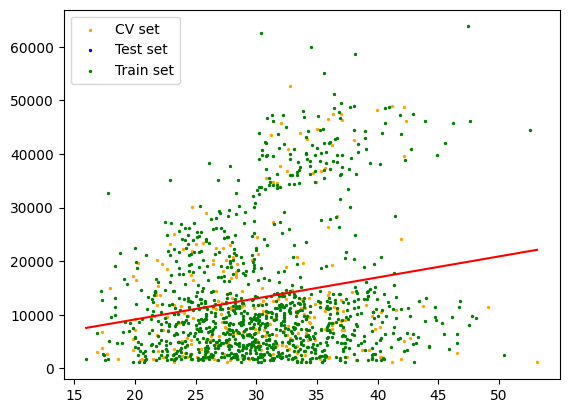

In [74]:
plot_model(model_1, 2)

## Drawing the contour plot

In [12]:
def plot_training(model, w_range, b_range, levels, onwards, title_text="Plot", title_text_pos=0.35, 
                  resolution=100, mplotlib=False, plotly_range="same", save=False):
    contour_w = np.arange(w_range[0], w_range[1]+1, resolution)
    contour_b = np.arange(b_range[0], b_range[1]+1, resolution)
    
    [W, B] = np.meshgrid(contour_w, contour_b)
    
    contour_cost = np.zeros((W.shape))
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            w = np.array((W[i][j],))
            b = B[i][j]
            contour_cost[i][j] = model.compute_cost(w, b, 0)
    
    w_hist = model.w_hist
    w_hist_plot = []
    b_hist_plot = model.b_hist
    j_hist_plot = model.j_hist
    
    for i in range(len(j_hist_plot)):
        w_hist_plot.append(list(w_hist[i])[0])

    converged_at = check_convergence(model)
    fig = plt.figure(figsize=(13, 13))
    fig.text(title_text_pos, 0.94, title_text, fontsize=20)
    fig.text(0.40, 0.91, f"Converged at: {converged_at}", fontsize=14)
    ax1 = fig.add_subplot(221)
    cs = ax1.contour(W, B, contour_cost, levels=levels) 
    ax1.plot(w_hist_plot, b_hist_plot, color='magenta')
    ax1.scatter(w_hist_plot, b_hist_plot, marker='*', s=40, c='red')
    ax1.set_xlabel('w')
    ax1.set_ylabel('b')
    if mplotlib:
        ax2 = fig.add_subplot(222, projection='3d')
        ax2.plot_surface(W, B, contour_cost, cmap='plasma')
        ax2.plot3D(w_hist_plot, b_hist_plot, j_hist_plot, c='black')
        ax2.set_xlabel('w')
        ax2.set_ylabel('b')
        ax2.set_zlabel('J')
        ax2.view_init(60, 60)
    else:
        if plotly_range!="same":
            contour_w = np.arange(plotly_range[0][0], plotly_range[0][1]+1, resolution)
            contour_b = np.arange(plotly_range[1][0], plotly_range[1][1]+1, resolution)
            
            [W, B] = np.meshgrid(contour_w, contour_b)
            
            contour_cost = np.zeros((W.shape))
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    w = np.array((W[i][j],))
                    b = B[i][j]
                    contour_cost[i][j] = model.compute_cost(w, b, 0)
        fig_2 = go.Figure(data=[go.Surface(z=contour_cost, x=contour_w, y=contour_b)])
        fig_2.add_scatter3d(x=w_hist_plot, y=b_hist_plot, z=j_hist_plot, marker=dict(size=2, color="white"))
        fig_2.update_layout(autosize=True,
                          width=700, height=700,
                          margin=dict(l=65, r=50, b=65, t=90))
        camera = dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=0, y=1, z=1)
        )
        if os.path.exists("plot_img/3d-plot.png"):
            os.remove("plot_img/3d-plot.png")
        fig_2.update_layout(scene_camera=camera)
        fig_2.write_image("plot_img/3d-plot.png")
        ax2 = fig.add_subplot(222)
        image = img.imread("plot_img/3d-plot.png")
        ax2.imshow(image)
        ax2.axis("off")
    ax3 = fig.add_subplot(223)
    ax3.plot(model.j_hist)
    ax3.set_title("Cost vs. updation step")
    ax3.set_xlabel("Updation step")
    ax3.set_ylabel("Cost")
    
    ax4 = fig.add_subplot(224)
    ax4.plot(range(onwards, len(model.j_hist)), model.j_hist[onwards:])
    ax4.set_title(f"update step {onwards} onwards")
    if save:
        img_name = "model_plots/"+title_text.replace(" ", "_")+".png"
        if os.path.exists(img_name):
            os.remove(img_name)
        fig.savefig(img_name, dpi='figure', bbox_inches='tight', pad_inches=0.5)
    plt.show()

Converged at updation step: 167


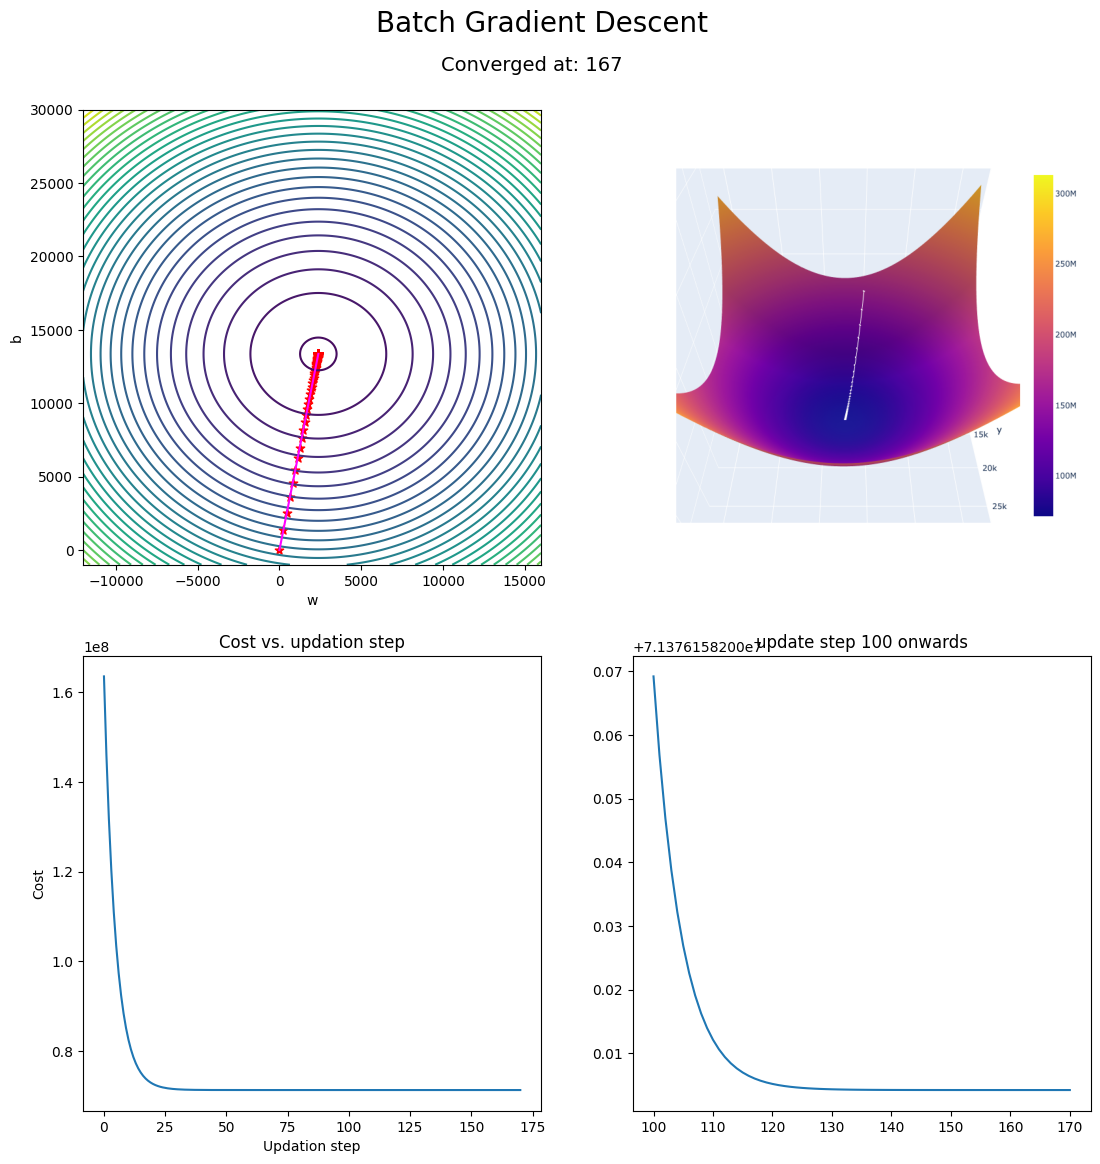

In [13]:
plot_training(model_1, (-12000, 16000), (-1000, 30000), 30, 100, "Batch Gradient Descent",
              plotly_range=((-12000, 16000), (-1000, 30000)), save=True)

# Mini-batch gradient descent
(with learning rate decay)
### model_2

Batch size: 128

In [14]:
model_2 = Model(X_raw, y_raw, 1, [80, 20, 0], 128)

Shape of X_train: (1071, 1)
Shape of X_cv: (267, 1)
Shape of X_test: (0, 1)
No. of batches: 9


In [15]:
model_2.batches

[(0, 128),
 (128, 256),
 (256, 384),
 (384, 512),
 (512, 640),
 (640, 768),
 (768, 896),
 (896, 1024),
 (1024, 1071)]

In [60]:
model_2.fit(alpha=0.5, lambda_=0, num_iters=25, 
            optimizer="GD", store_hist=True, compute_test_error=False, decay_rate=3)

At epoch: 3| At updation step: 23
	 j: 72088307.86618428
	 w: [1898.86392917]
	 b: 11734.222641721148
At epoch: 6| At updation step: 46
	 j: 71103091.69107796
	 w: [2057.5060318]
	 b: 12645.571769488653
At epoch: 8| At updation step: 69
	 j: 70984517.69481897
	 w: [2068.28027404]
	 b: 12897.815320878717
At epoch: 11| At updation step: 92
	 j: 70941798.51766911
	 w: [2120.96575575]
	 b: 13042.411721592138
At epoch: 13| At updation step: 115
	 j: 70934922.56147026
	 w: [2096.52820758]
	 b: 13092.115941563321
At epoch: 16| At updation step: 138
	 j: 70926453.18831731
	 w: [2126.35566722]
	 b: 13149.136957103055
At epoch: 18| At updation step: 161
	 j: 70925182.6251797
	 w: [2120.68636874]
	 b: 13169.003759681806
At epoch: 21| At updation step: 184
	 j: 70924945.1918156
	 w: [2114.96112222]
	 b: 13177.663404709663
At epoch: 23| At updation step: 207
	 j: 70923220.52371988
	 w: [2122.40171941]
	 b: 13207.31866047372
At epoch: 25| At updation step: 224
	 j: 70922881.27874406
	 w: [2126.88561

In [61]:
check_convergence(model_2)

Convergence: False


False

As seen above, the model is not converging. It reaches very close to the global minimum but oscillates there because of small batch size. Oscillations are dampened because of learning rate decay

The model oscillates at the end. Mini-batch should work better on larger dataset.

Convergence: False


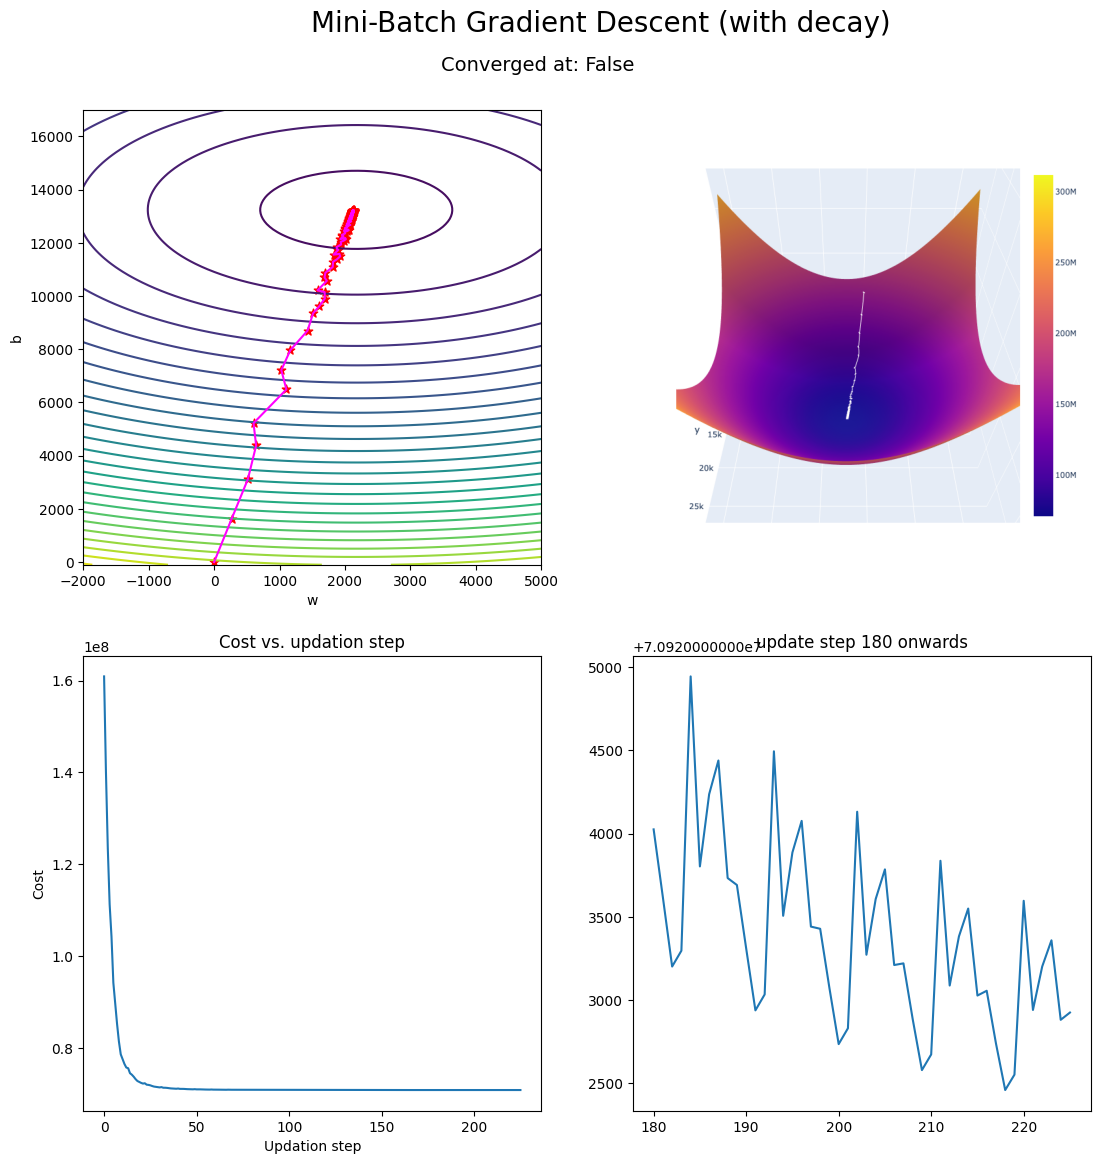

In [68]:
plot_training(model_2, (-2000, 5000), (-100, 17000), 30, 180, "Mini-Batch Gradient Descent (with decay)", 0.30, 
              plotly_range=((-12000, 16000), (-1000, 30000)), save=True)

# Stochastic gradient descent
(with learning rate decay)
### model_3
Batch size: 1

In [19]:
model_3 = Model(X_raw, y_raw, 1, [80, 20, 0], 1)

Shape of X_train: (1071, 1)
Shape of X_cv: (267, 1)
Shape of X_test: (0, 1)
No. of batches: 1071


In [65]:
model_3.fit(alpha=0.08, lambda_=0, num_iters=5, 
            optimizer="GD", store_hist=True, compute_test_error=False, decay_rate=35)

At epoch: 1| At updation step: 536
	 j: 79579161.3646889
	 w: [2042.618234]
	 b: 8960.023547057826
At epoch: 2| At updation step: 1072
	 j: 71587895.02120231
	 w: [2083.23574101]
	 b: 12049.944270692544
At epoch: 2| At updation step: 1608
	 j: 71250167.89354426
	 w: [2293.07491269]
	 b: 12394.73065266045
At epoch: 3| At updation step: 2144
	 j: 71040623.00302628
	 w: [2271.24034369]
	 b: 12850.136600264224
At epoch: 3| At updation step: 2680
	 j: 71037768.86362848
	 w: [2331.07622088]
	 b: 12843.2000179607
At epoch: 4| At updation step: 3216
	 j: 71010378.58018172
	 w: [2321.49815879]
	 b: 13025.954707834839
At epoch: 4| At updation step: 3752
	 j: 71014641.36262679
	 w: [2353.27701973]
	 b: 12965.587294262445
At epoch: 5| At updation step: 4288
	 j: 71007660.4161573
	 w: [2341.47001947]
	 b: 13076.647607056719
At epoch: 5| At updation step: 4824
	 j: 71009611.53369816
	 w: [2363.18128667]
	 b: 13015.884079341577
At epoch: 5| At updation step: 5354
	 j: 71007378.6634779
	 w: [2357.9188

Convergence: False


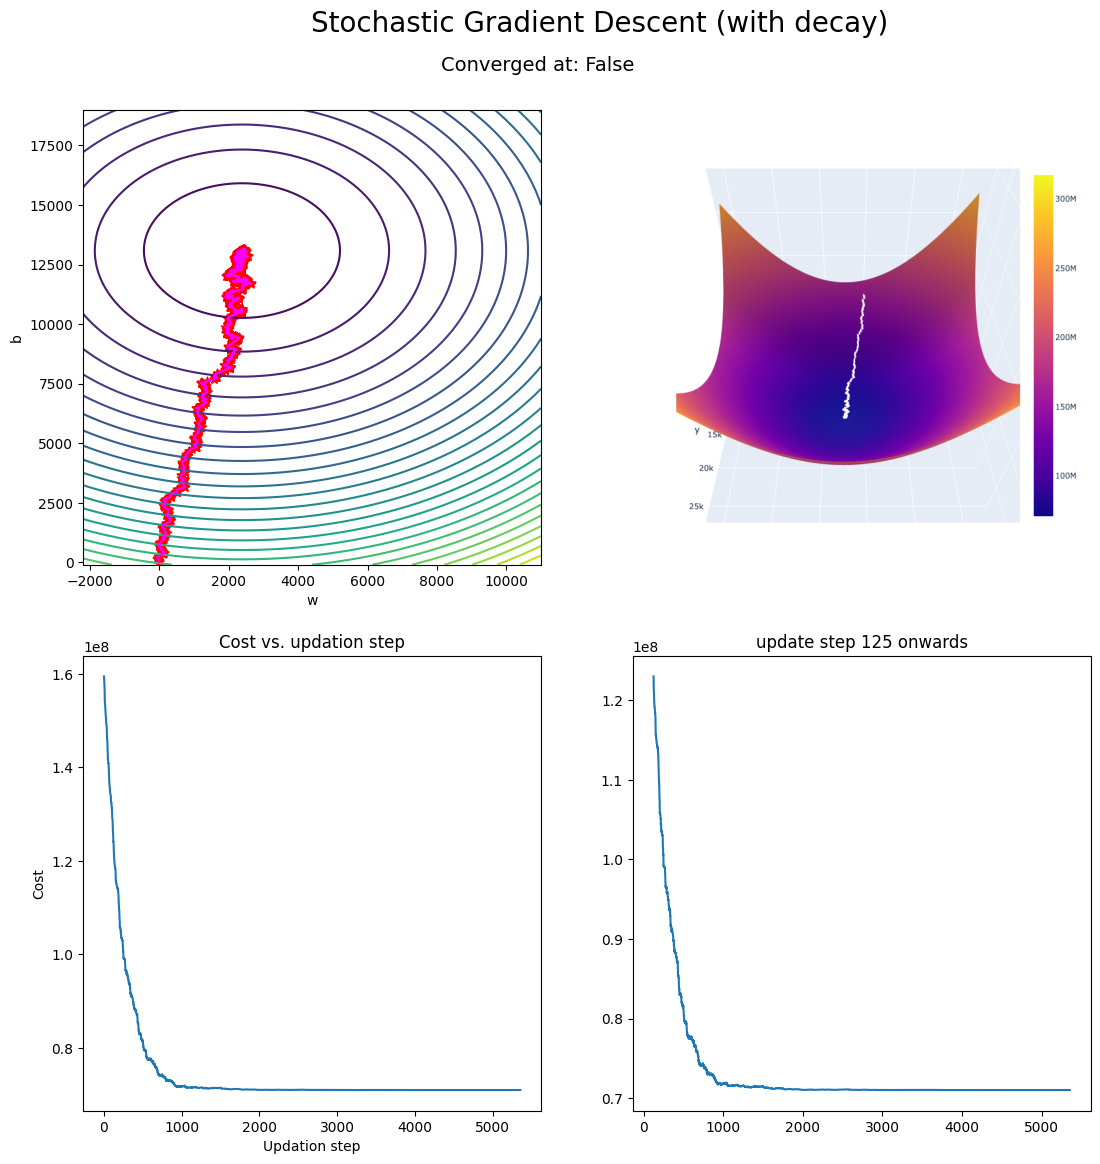

In [67]:
plot_training(model_3, (-2200, 11000), (-100, 19000), 30, 125, "Stochastic Gradient Descent (with decay)", 0.30, 
              plotly_range=((-12000, 16000), (-1000, 30000)), save=True)

Works very well with learning rate decay. Without it, it's just a mess!

<b>Learning rate decay makes a huge difference for mini-batch and stochastic GD</b>

# Momentum
## (with batch gradient descent)

### model_4
alpha=0.09 | beta = 0.9

In [22]:
model_4 = Model(X_raw, y_raw, 1, [80, 20, 0], -1)

Shape of X_train: (1071, 1)
Shape of X_cv: (267, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [23]:
model_4.fit(alpha=0.09, lambda_=0, num_iters=320, 
            optimizer="Momentum", hyperparameters=(0.9,), store_hist=True, compute_test_error=False)

At epoch: 32| At updation step: 32
	 j: 71902352.06093663
	 w: [3001.73927387]
	 b: 15480.183615962313
At epoch: 64| At updation step: 64
	 j: 69167847.70821379
	 w: [2480.18411509]
	 b: 12790.486448037915
At epoch: 96| At updation step: 96
	 j: 69099935.42412937
	 w: [2560.35756229]
	 b: 13203.946635788725
At epoch: 128| At updation step: 128
	 j: 69098729.07379194
	 w: [2550.09790259]
	 b: 13151.036838685335
At epoch: 160| At updation step: 160
	 j: 69098718.66069564
	 w: [2550.94963845]
	 b: 13155.429301291828
At epoch: 192| At updation step: 192
	 j: 69098718.6743791
	 w: [2551.00267305]
	 b: 13155.70280446608
At epoch: 224| At updation step: 224
	 j: 69098718.65861998
	 w: [2550.95479391]
	 b: 13155.455888324223
At epoch: 256| At updation step: 256
	 j: 69098718.65675236
	 w: [2550.96979477]
	 b: 13155.53324884089
At epoch: 288| At updation step: 288
	 j: 69098718.65663473
	 w: [2550.96616837]
	 b: 13155.51454724338
At epoch: 319| At updation step: 319
	 j: 69098718.65662934
	 w: 

In [24]:
check_convergence(model_4)

Converged at updation step: 298


298

Converged at updation step: 298


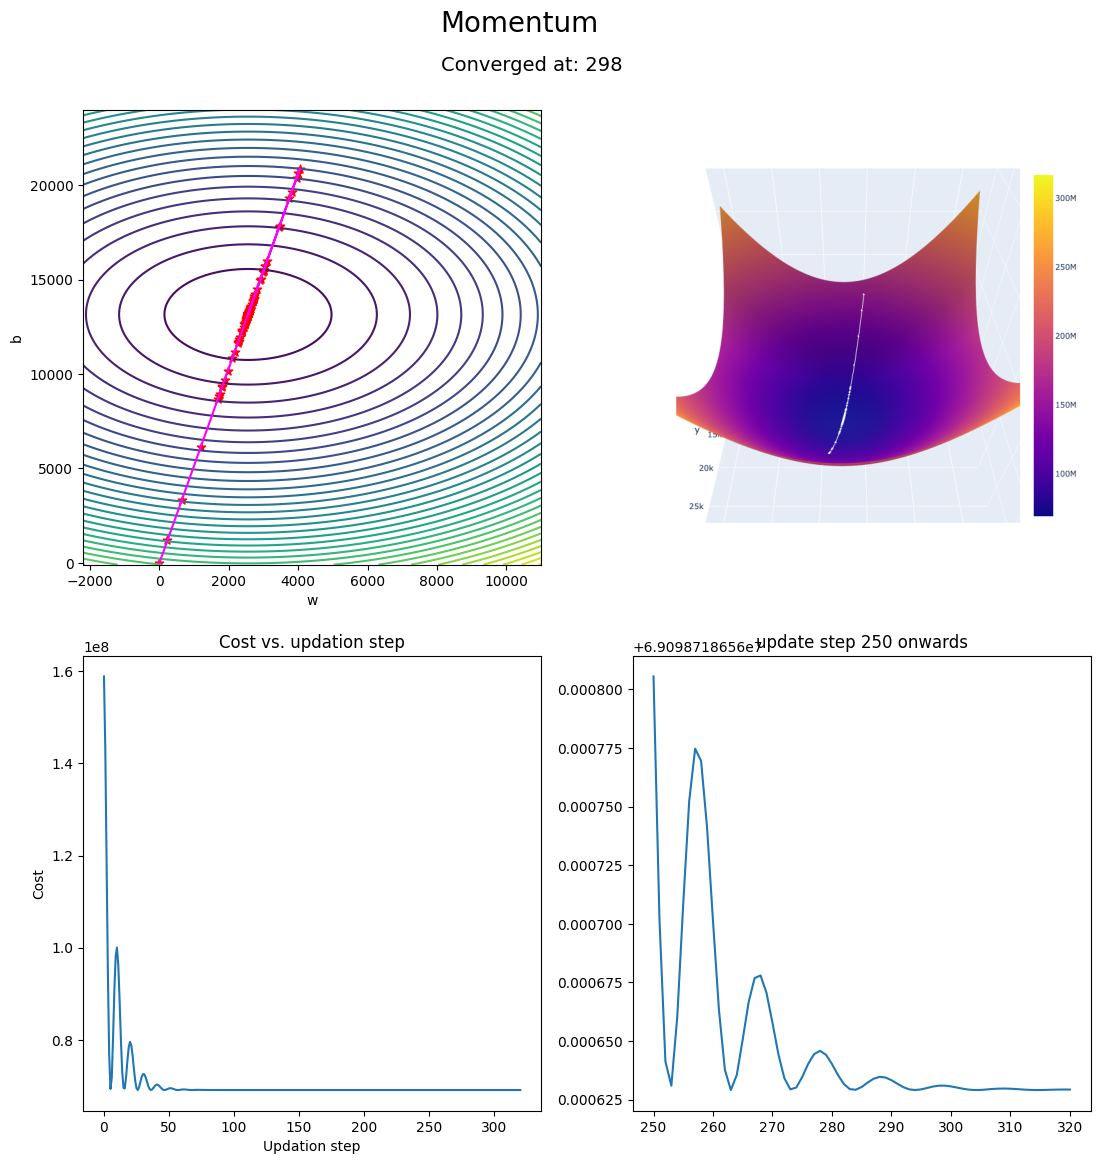

In [25]:
plot_training(model_4, (-2200, 11000), (-100, 24000), 30, 250, "Momentum", 0.40, 
              plotly_range=((-12000, 16000), (-1000, 30000)), save=True)

Momentum oscillates in the end and overshoots the minima but then comes back.

# Nesterov Accelerated Gradient (NAG)
## (with batch gradient descent)

### model_5
alpha=0.5 | beta=0.9

In [26]:
model_5 = Model(X_raw, y_raw, 1, [80, 20, 0], -1)

Shape of X_train: (1071, 1)
Shape of X_cv: (267, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [27]:
model_5.fit(alpha=0.5, lambda_=0, num_iters=50, 
            optimizer="NAG", hyperparameters=(0.9,), store_hist=True, compute_test_error=False)

At epoch: 5| At updation step: 5
	 j: 69798908.22947054
	 w: [2510.19774021]
	 b: 14591.464538313001
At epoch: 10| At updation step: 10
	 j: 68864153.55331571
	 w: [2275.56420368]
	 b: 13227.569227211861
At epoch: 15| At updation step: 15
	 j: 68864259.69091937
	 w: [2274.63099349]
	 b: 13222.144593444385
At epoch: 20| At updation step: 20
	 j: 68864027.35607125
	 w: [2279.14116028]
	 b: 13248.361627179358
At epoch: 25| At updation step: 25
	 j: 68864017.03926653
	 w: [2278.28594383]
	 b: 13243.390361273217
At epoch: 30| At updation step: 30
	 j: 68864016.92558031
	 w: [2278.36814977]
	 b: 13243.86821406764
At epoch: 35| At updation step: 35
	 j: 68864016.9255749
	 w: [2278.36802918]
	 b: 13243.867513106043
At epoch: 40| At updation step: 40
	 j: 68864016.92554975
	 w: [2278.36653558]
	 b: 13243.858830970503
At epoch: 45| At updation step: 45
	 j: 68864016.92554857
	 w: [2278.36682672]
	 b: 13243.860523358522
At epoch: 49| At updation step: 49
	 j: 68864016.92554857
	 w: [2278.36679283

In [28]:
check_convergence(model_5)

Converged at updation step: 43


43

Converged at updation step: 43


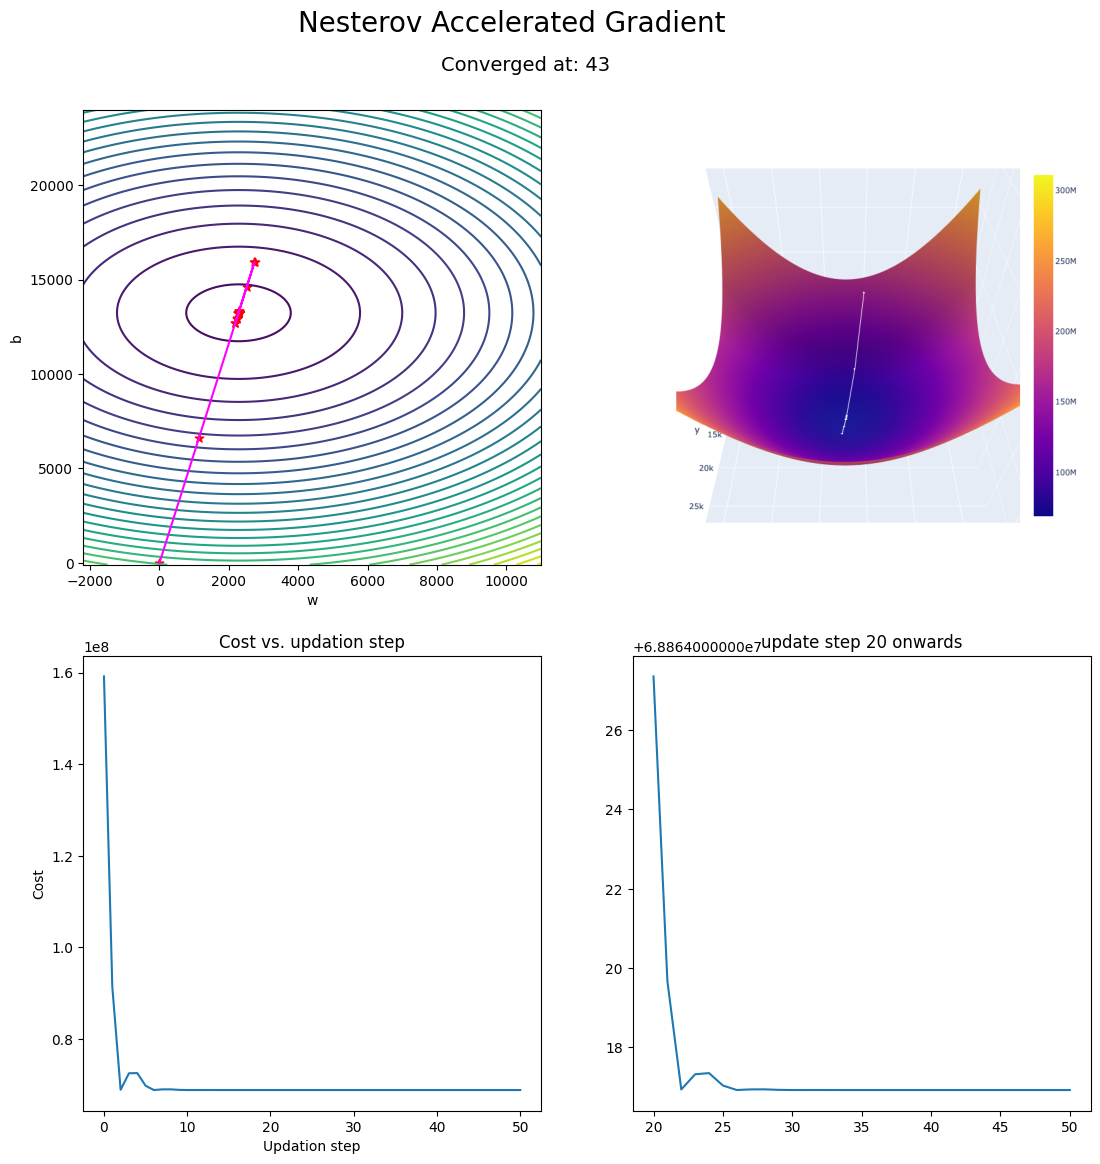

In [29]:
plot_training(model_5, (-2200, 11000), (-100, 24000), 30, 20, "Nesterov Accelerated Gradient", 0.29, 
              plotly_range=((-12000, 16000), (-1000, 30000)), save=True)

In NAG, the oscillations are dampened, and it converges much faster.

# Adaptive Gradient (AdaGrad)
## (with batch gradient descent)

### model_6
alpha=10000 | E=1e-08

In [30]:
model_6 = Model(X_raw, y_raw, 1, [80, 20, 0], -1)

Shape of X_train: (1071, 1)
Shape of X_cv: (267, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [31]:
model_6.fit(alpha=10000, lambda_=0, num_iters=20, 
            optimizer="AdaGrad", hyperparameters=(1e-08,), store_hist=True, compute_test_error=False)

At epoch: 2| At updation step: 2
	 j: 68591325.3386365
	 w: [434.38318531]
	 b: 12328.895532499351
At epoch: 4| At updation step: 4
	 j: 66452842.229021214
	 w: [2249.036822]
	 b: 13092.609296286839
At epoch: 6| At updation step: 6
	 j: 66447514.214608654
	 w: [2331.87641071]
	 b: 13144.947643193096
At epoch: 8| At updation step: 8
	 j: 66447499.12334988
	 w: [2335.62809534]
	 b: 13148.53601721866
At epoch: 10| At updation step: 10
	 j: 66447499.07282751
	 w: [2335.79800091]
	 b: 13148.782040548473
At epoch: 12| At updation step: 12
	 j: 66447499.072631896
	 w: [2335.80569556]
	 b: 13148.798908210249
At epoch: 14| At updation step: 14
	 j: 66447499.07263107
	 w: [2335.80604403]
	 b: 13148.800064677866
At epoch: 16| At updation step: 16
	 j: 66447499.07263107
	 w: [2335.80605982]
	 b: 13148.800143966706
At epoch: 18| At updation step: 18
	 j: 66447499.07263107
	 w: [2335.80606053]
	 b: 13148.800149402847
At epoch: 19| At updation step: 19
	 j: 66447499.07263107
	 w: [2335.80606057]
	 b:

Converged at updation step: 14


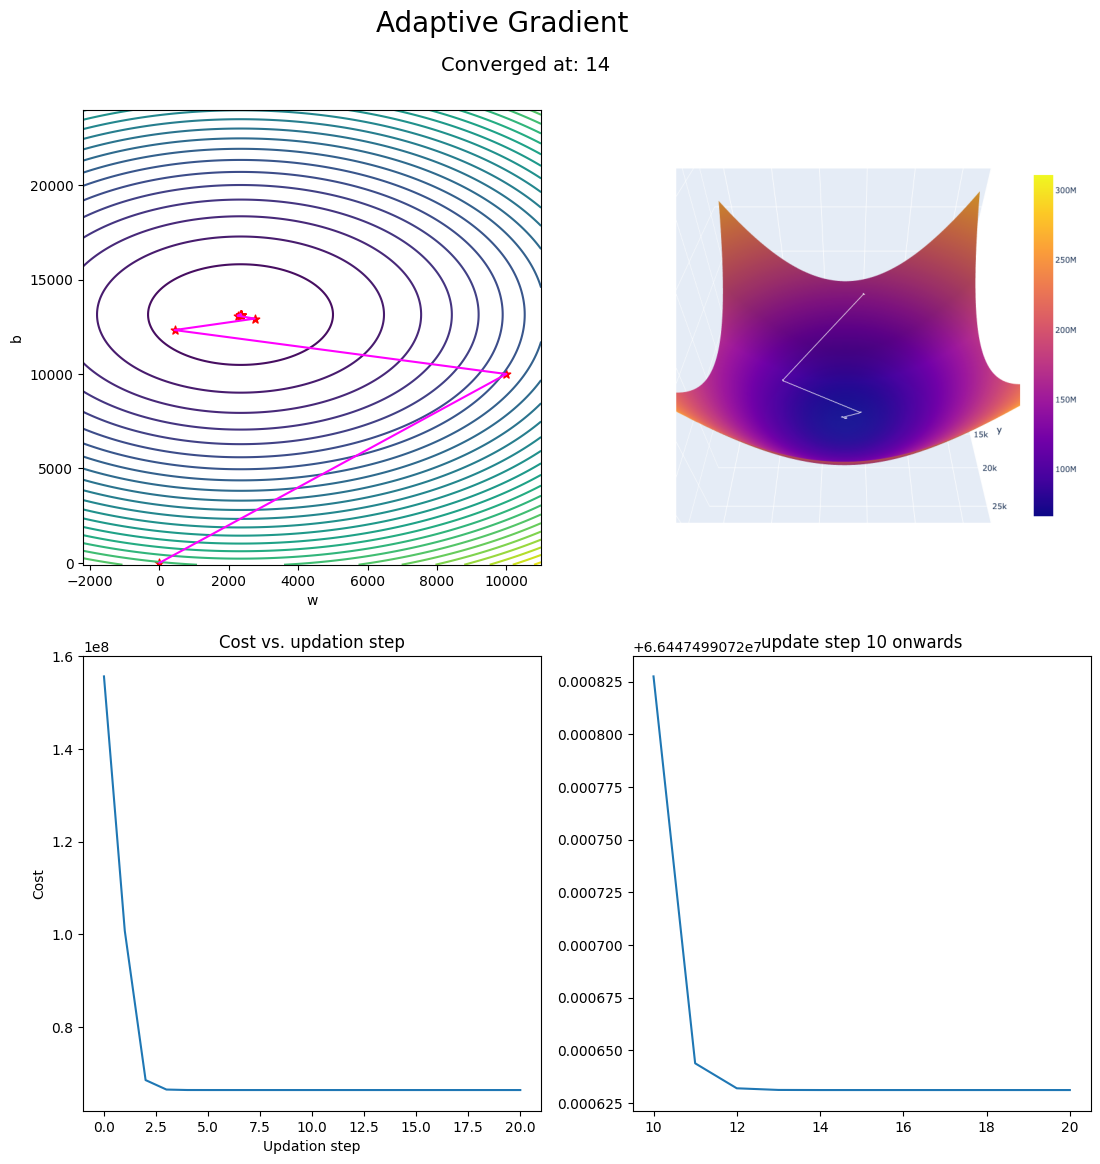

In [32]:
plot_training(model_6, (-2200, 11000), (-100, 24000), 30, 10, "Adaptive Gradient", 0.35, 
              plotly_range=((-12000, 16000), (-1000, 30000)), save=True)

Converges very fast with a huge alpha (10000). This is because the gradients are big. Initial steps are a little too big though. Should work better on data with sparse columns.

# Root Mean Squares Propagation (RMSprop)
## (with batch gradient descent)

### model_7
alpha=100 | beta=0.999 | E=1e-08

In [33]:
model_7 = Model(X_raw, y_raw, 1, [80, 20, 0], -1)

Shape of X_train: (1071, 1)
Shape of X_cv: (267, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [34]:
model_7.fit(alpha=100, lambda_=0, num_iters=120, 
            optimizer="RMSprop", hyperparameters=(0.999, 1e-08), store_hist=True, compute_test_error=False)

At epoch: 12| At updation step: 12
	 j: 69581757.89294255
	 w: [2492.75253872]
	 b: 11637.200177788827
At epoch: 24| At updation step: 24
	 j: 68333371.10105848
	 w: [2492.7525934]
	 b: 12982.672377494315
At epoch: 36| At updation step: 36
	 j: 68301645.4472946
	 w: [2492.7525934]
	 b: 13197.428706294213
At epoch: 48| At updation step: 48
	 j: 68300851.25582911
	 w: [2492.7525934]
	 b: 13231.472372000651
At epoch: 60| At updation step: 60
	 j: 68300831.84234402
	 w: [2492.7525934]
	 b: 13236.805245557724
At epoch: 72| At updation step: 72
	 j: 68300831.37913491
	 w: [2492.7525934]
	 b: 13237.630578777525
At epoch: 84| At updation step: 84
	 j: 68300831.36834867
	 w: [2492.7525934]
	 b: 13237.75676213646
At epoch: 96| At updation step: 96
	 j: 68300831.3681036
	 w: [2492.7525934]
	 b: 13237.77581859782
At epoch: 108| At updation step: 108
	 j: 68300831.36809817
	 w: [2492.7525934]
	 b: 13237.778661175098
At epoch: 119| At updation step: 119
	 j: 68300831.36809804
	 w: [2492.7525934]
	 b

Converged at updation step: 112


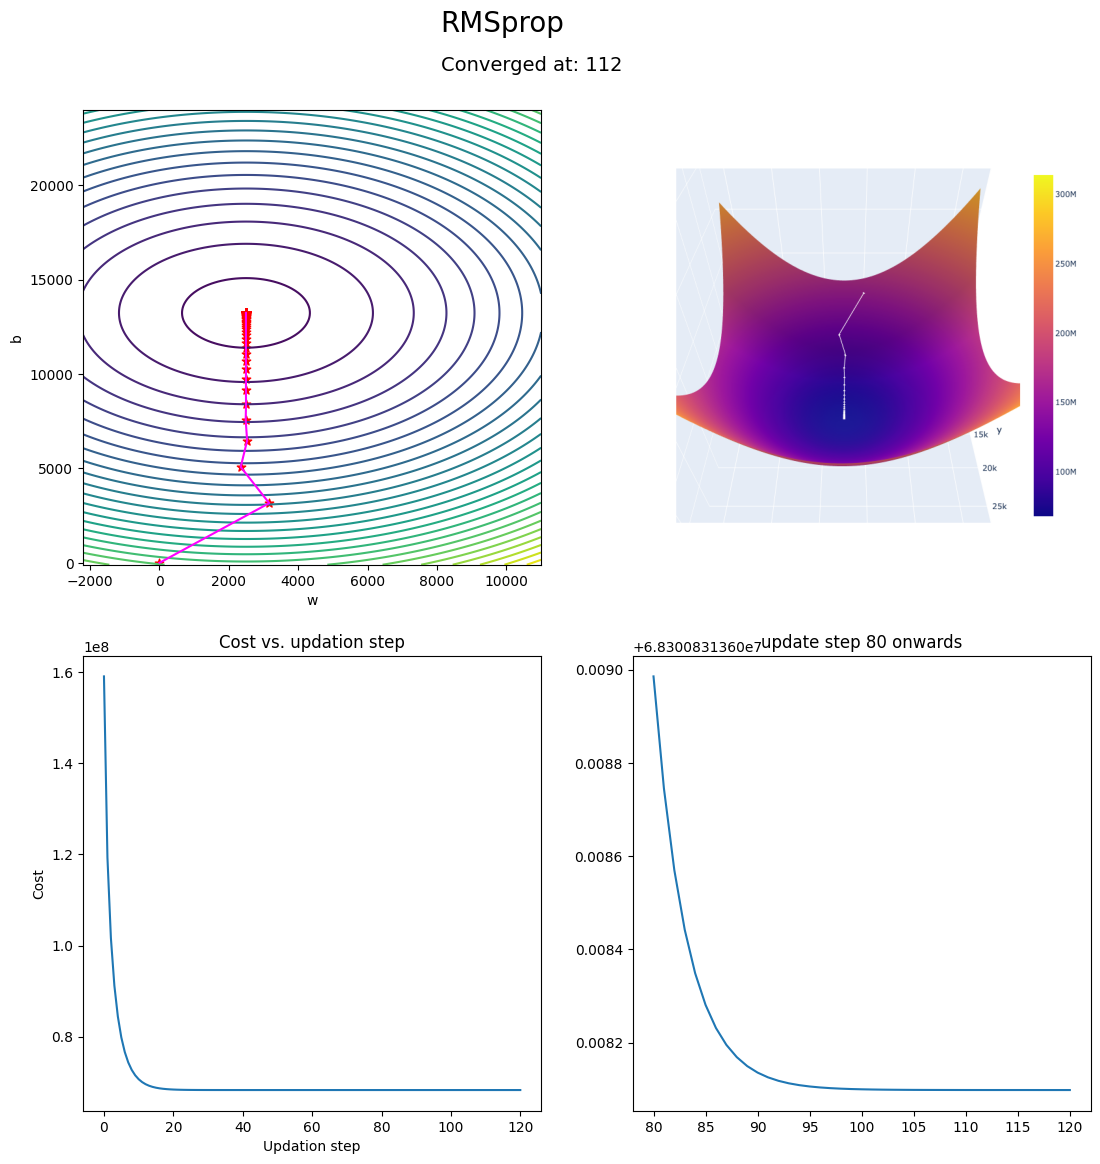

In [35]:
plot_training(model_7, (-2200, 11000), (-100, 24000), 30, 80, "RMSprop", 0.40, 
              plotly_range=((-12000, 16000), (-1000, 30000)), save=True)

Again, a very large alpha(=100) is used

# Adaptive Moment Estimation (Adam)
## (with batch gradient descent)

### model_8
alpha=500 | beta1=0.7 | beta2=0.999 | E=1e-08

In [36]:
model_8 = Model(X_raw, y_raw, 1, [80, 20, 0], -1)

Shape of X_train: (1071, 1)
Shape of X_cv: (267, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [37]:
model_8.fit(alpha=500, lambda_=0, num_iters=135, 
            optimizer="Adam", hyperparameters=(0.7, 0.999, 1e-08), 
            store_hist=True, compute_test_error=False, w=np.array([10000]), b=100)

At epoch: 14| At updation step: 14
	 j: 93266927.92327346
	 w: [4120.3882725]
	 b: 6534.291893909474
At epoch: 28| At updation step: 28
	 j: 72395844.56539068
	 w: [2323.97543739]
	 b: 10689.595978394502
At epoch: 42| At updation step: 42
	 j: 69372704.81091195
	 w: [2306.23625196]
	 b: 12555.057326797707
At epoch: 56| At updation step: 56
	 j: 69143548.39666663
	 w: [2316.96428375]
	 b: 13120.707848442988
At epoch: 70| At updation step: 70
	 j: 69136154.00721811
	 w: [2315.86217287]
	 b: 13230.750009237037
At epoch: 84| At updation step: 84
	 j: 69136079.97216353
	 w: [2315.95595828]
	 b: 13242.692202352402
At epoch: 98| At updation step: 98
	 j: 69136079.9485881
	 w: [2315.94834111]
	 b: 13242.990266025628
At epoch: 112| At updation step: 112
	 j: 69136079.94613862
	 w: [2315.94888367]
	 b: 13242.922299100339
At epoch: 126| At updation step: 126
	 j: 69136079.94613664
	 w: [2315.94886019]
	 b: 13242.919752699558
At epoch: 134| At updation step: 134
	 j: 69136079.94613653
	 w: [2315.9

Converged at updation step: 131


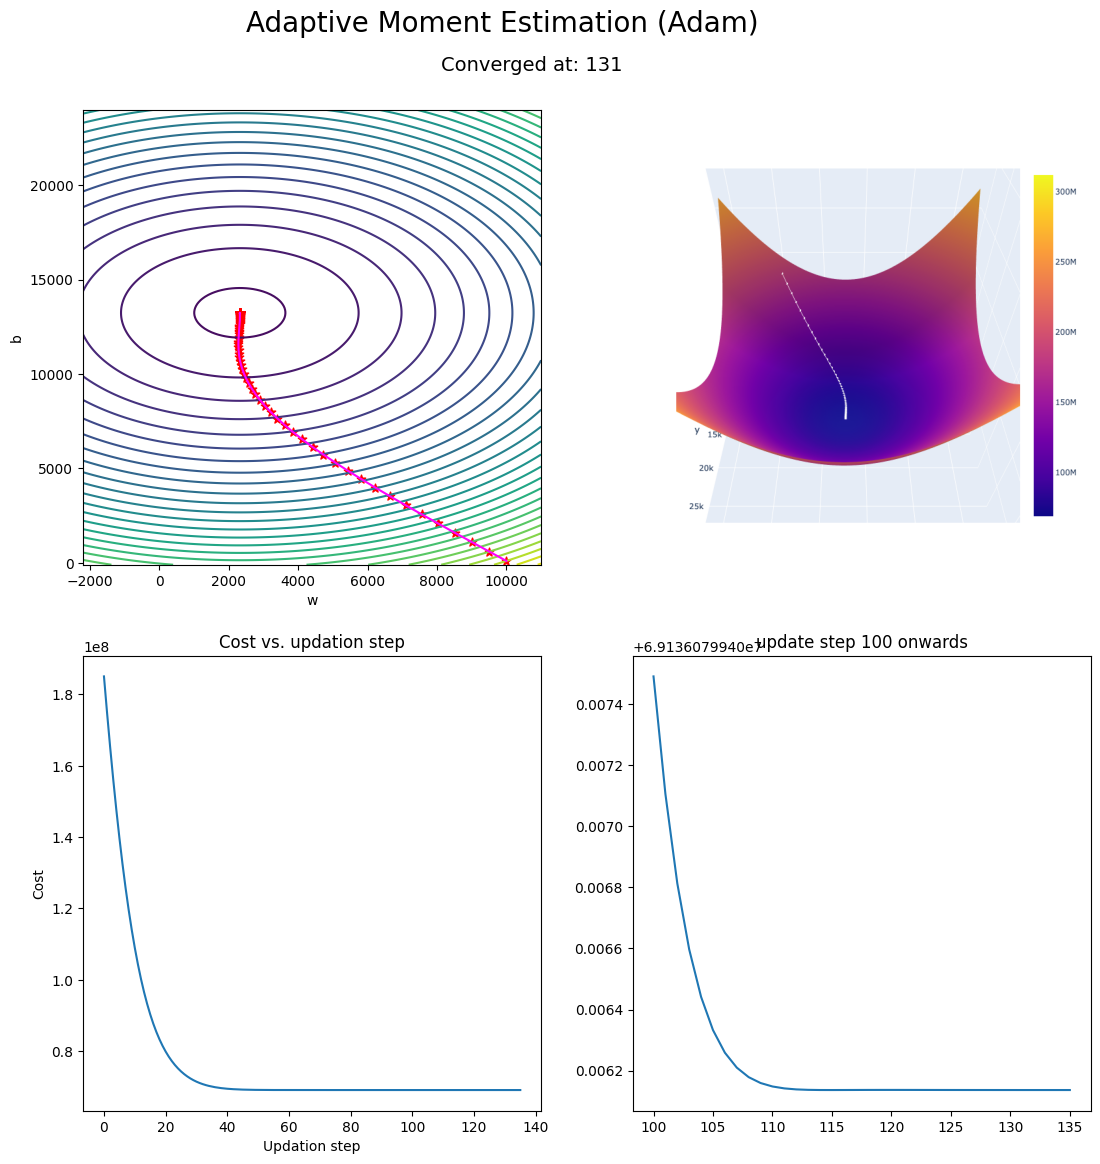

In [38]:
plot_training(model_8, (-2200, 11000), (-100, 24000), 30, 100, "Adaptive Moment Estimation (Adam)", 0.25, 
              plotly_range=((-12000, 16000), (-1000, 30000)), save=True)

Adam can also show oscillations but the hyperparameters have been adjusted to allow faster convergence (momentum part has been dampened)

# DATASET 2

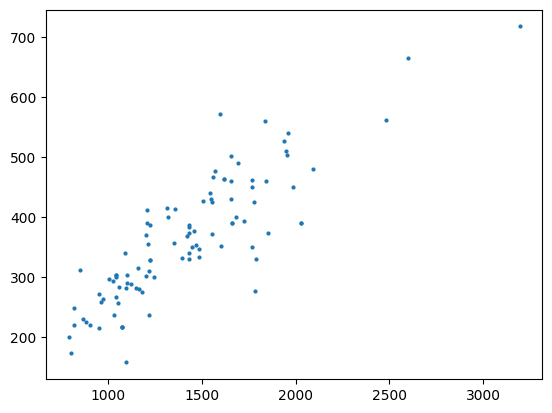

In [39]:
data = np.loadtxt('data/houses.txt', delimiter=',')
X_raw_2 = data[:, :1]
y_raw_2 = data[:, 4]
plot(X_raw_2, y_raw_2)

## Batch GD (on data 2)

### model_9

In [40]:
model_9 = Model(X_raw_2, y_raw_2, 1, [80, 20, 0], -1)

Shape of X_train: (80, 1)
Shape of X_cv: (20, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [57]:
model_9.fit(alpha=0.5, lambda_=0, num_iters=40, 
            optimizer="GD", hyperparameters=None, 
            store_hist=True, compute_test_error=False)

At epoch: 4| At updation step: 4
	 j: 1708.588815143999
	 w: [86.32286716]
	 b: 341.9704921875
At epoch: 8| At updation step: 8
	 j: 1433.2342925325497
	 w: [91.71804635]
	 b: 363.34364794921873
At epoch: 12| At updation step: 12
	 j: 1432.1586889285986
	 w: [92.05524505]
	 b: 364.67947018432614
At epoch: 16| At updation step: 16
	 j: 1432.1544873520209
	 w: [92.07631997]
	 b: 364.7629590740204
At epoch: 20| At updation step: 20
	 j: 1432.1544709396126
	 w: [92.07763715]
	 b: 364.7681771296263
At epoch: 24| At updation step: 24
	 j: 1432.154470875501
	 w: [92.07771948]
	 b: 364.76850325810165
At epoch: 28| At updation step: 28
	 j: 1432.154470875251
	 w: [92.07772462]
	 b: 364.7685236411313
At epoch: 32| At updation step: 32
	 j: 1432.1544708752494
	 w: [92.07772494]
	 b: 364.7685249150707
At epoch: 36| At updation step: 36
	 j: 1432.1544708752497
	 w: [92.07772496]
	 b: 364.7685249946919
At epoch: 39| At updation step: 39
	 j: 1432.1544708752501
	 w: [92.07772497]
	 b: 364.76852499933

In [58]:
check_convergence(model_9)

Converged at updation step: 30


30

Converged at updation step: 30


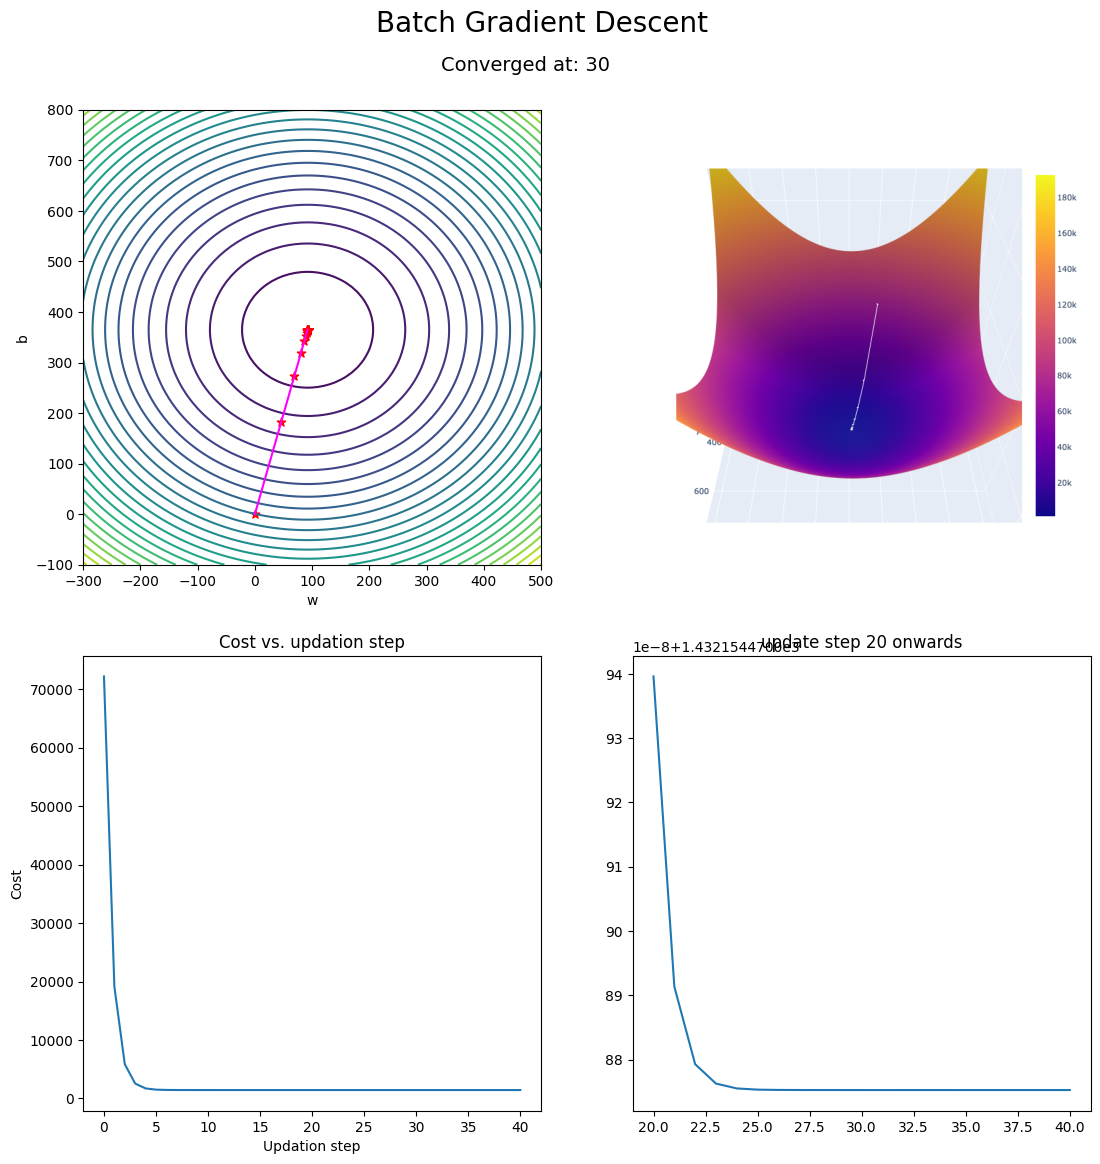

In [59]:
plot_training(model_9, (-300, 500), (-100, 800), 30, 20, "Batch Gradient Descent", 0.35, 10, plotly_range="same")

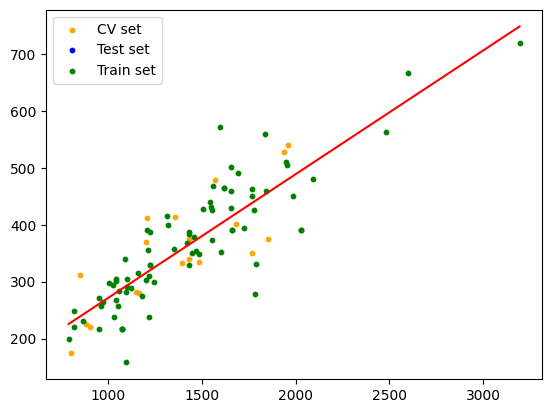

In [44]:
plot_model(model_9, 10)

## Momentum (on data 2)

### model_10

In [45]:
model_10 = Model(X_raw_2, y_raw_2, 1, [80, 20, 0], -1)

Shape of X_train: (80, 1)
Shape of X_cv: (20, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [46]:
model_10.fit(alpha=0.3, lambda_=0, num_iters=100, 
            optimizer="Momentum", hyperparameters=(0.6,), 
            store_hist=True, compute_test_error=False)

At epoch: 10| At updation step: 10
	 j: 1835.1899338853777
	 w: [87.62634019]
	 b: 340.56925905267224
At epoch: 20| At updation step: 20
	 j: 1562.4753915815072
	 w: [93.23445581]
	 b: 362.36580762162305
At epoch: 30| At updation step: 30
	 j: 1562.1025189460609
	 w: [93.45609654]
	 b: 363.22723833920566
At epoch: 40| At updation step: 40
	 j: 1562.1022300803595
	 w: [93.45188612]
	 b: 363.2108740796136
At epoch: 50| At updation step: 50
	 j: 1562.1021932008298
	 w: [93.44998175]
	 b: 363.20347253773764
At epoch: 60| At updation step: 60
	 j: 1562.1021926999933
	 w: [93.44975202]
	 b: 363.2025796845431
At epoch: 70| At updation step: 70
	 j: 1562.1021926966205
	 w: [93.44973276]
	 b: 363.20250479711115
At epoch: 80| At updation step: 80
	 j: 1562.1021926966082
	 w: [93.44973156]
	 b: 363.20250016098765
At epoch: 90| At updation step: 90
	 j: 1562.1021926966077
	 w: [93.44973152]
	 b: 363.20249999256595
At epoch: 99| At updation step: 99
	 j: 1562.102192696608
	 w: [93.44973152]
	 b: 36

Converged at updation step: 70


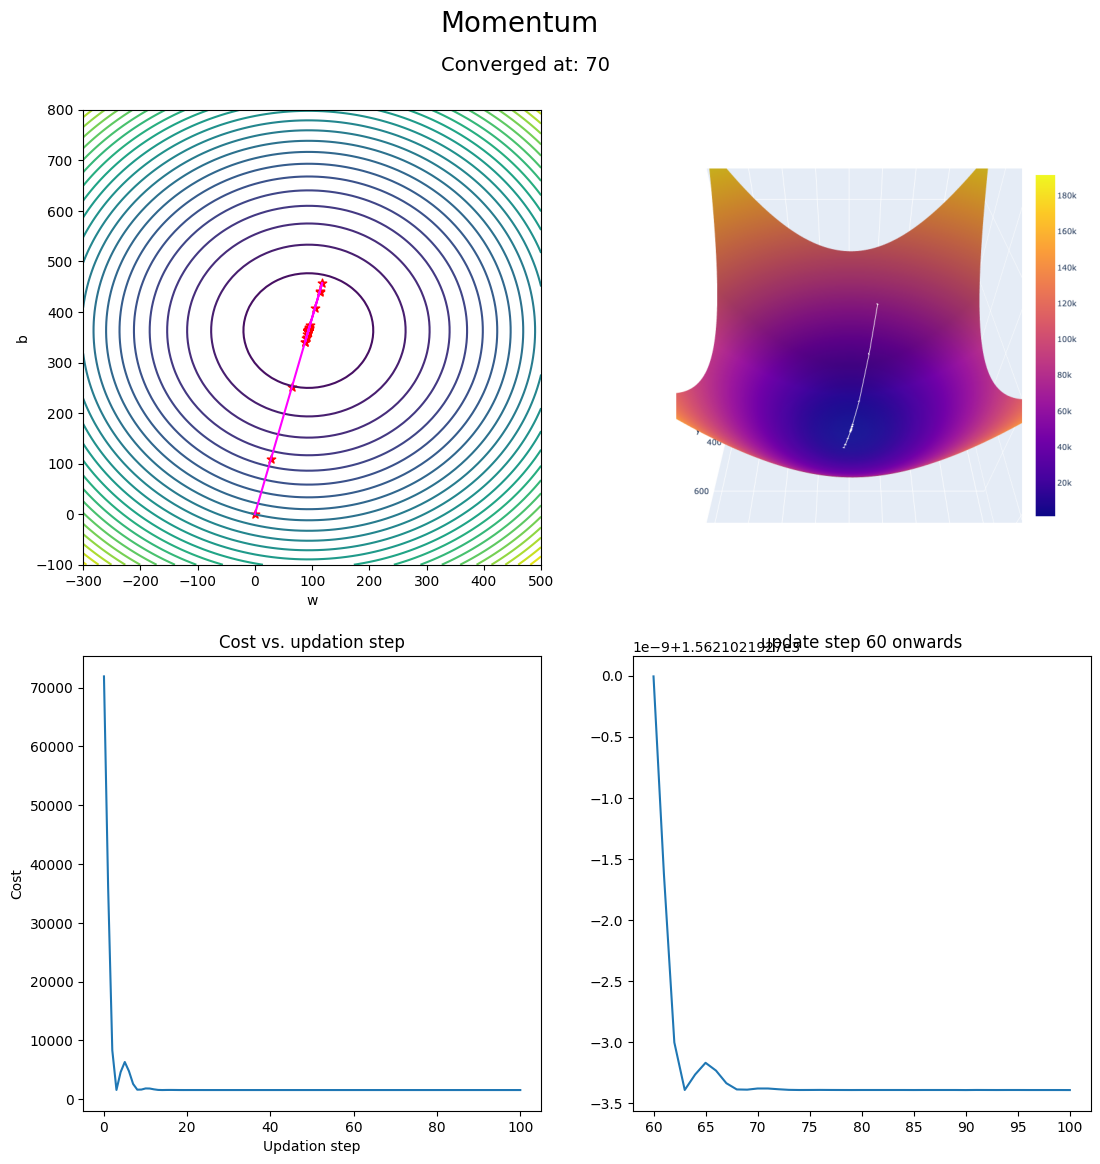

In [47]:
plot_training(model_10, (-300, 500), (-100, 800), 30, 60, "Momentum", 0.40, 10, plotly_range="same")

## NAG (on data 2)

### model_11

In [48]:
model_11 = Model(X_raw_2, y_raw_2, 1, [80, 20, 0], -1)

Shape of X_train: (80, 1)
Shape of X_cv: (20, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [49]:
model_11.fit(alpha=0.3, lambda_=0, num_iters=100, 
            optimizer="NAG", hyperparameters=(0.6,), 
            store_hist=True, compute_test_error=False)

At epoch: 10| At updation step: 10
	 j: 1364.851578171818
	 w: [84.24087827]
	 b: 362.92021146709016
At epoch: 20| At updation step: 20
	 j: 1364.510038658105
	 w: [84.43993884]
	 b: 363.77778921045496
At epoch: 30| At updation step: 30
	 j: 1364.5086744137384
	 w: [84.42832297]
	 b: 363.7277466008939
At epoch: 40| At updation step: 40
	 j: 1364.5086740360682
	 w: [84.42812718]
	 b: 363.72690310001116
At epoch: 50| At updation step: 50
	 j: 1364.5086740360632
	 w: [84.42812643]
	 b: 363.72689989857776
At epoch: 60| At updation step: 60
	 j: 1364.5086740360634
	 w: [84.42812646]
	 b: 363.72689999805783
At epoch: 70| At updation step: 70
	 j: 1364.5086740360634
	 w: [84.42812646]
	 b: 363.7268999999903
At epoch: 80| At updation step: 80
	 j: 1364.5086740360634
	 w: [84.42812646]
	 b: 363.72690000000017
At epoch: 90| At updation step: 90
	 j: 1364.5086740360632
	 w: [84.42812646]
	 b: 363.7269
At epoch: 99| At updation step: 99
	 j: 1364.5086740360632
	 w: [84.42812646]
	 b: 363.7269
At e

Converged at updation step: 45


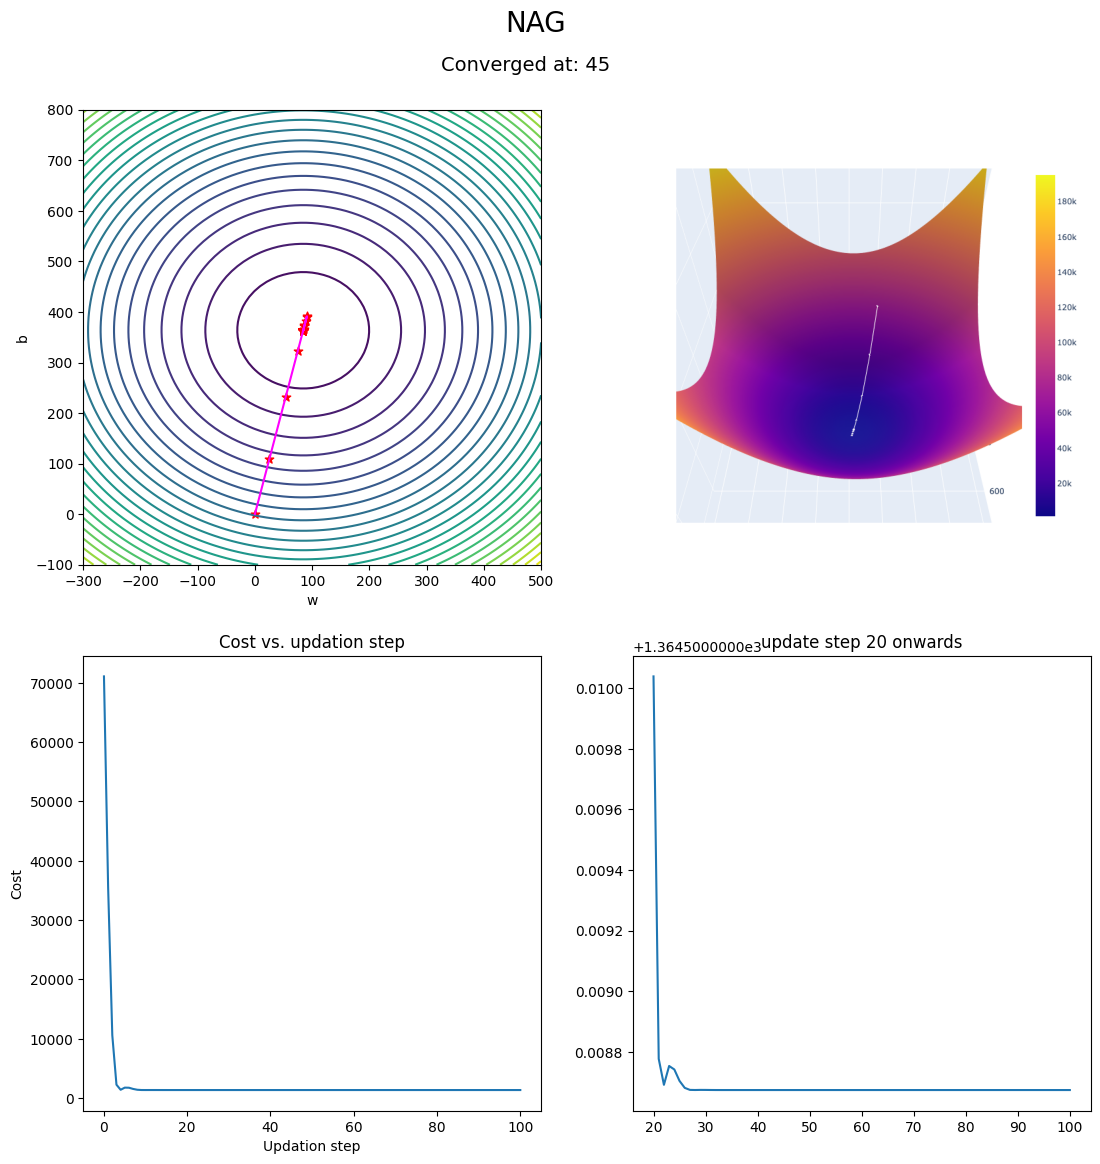

In [50]:
plot_training(model_11, (-300, 500), (-100, 800), 30, 20, "NAG", 0.45, 10, plotly_range="same")

## RMSprop (on data 2)

### model_12

In [51]:
model_12 = Model(X_raw_2, y_raw_2, 1, [80, 20, 0], -1)

Shape of X_train: (80, 1)
Shape of X_cv: (20, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [52]:
model_12.fit(alpha=6, lambda_=0, num_iters=35, 
            optimizer="RMSprop", hyperparameters=(0.999, 1e-08), 
            store_hist=True, compute_test_error=False)

At epoch: 4| At updation step: 4
	 j: 1920.1803205010706
	 w: [83.59381139]
	 b: 333.9347957524761
At epoch: 8| At updation step: 8
	 j: 1589.4767743047028
	 w: [88.49707085]
	 b: 357.1522387135708
At epoch: 12| At updation step: 12
	 j: 1587.2787636264918
	 w: [88.5650509]
	 b: 359.08137344053154
At epoch: 16| At updation step: 16
	 j: 1587.2637999687527
	 w: [88.56602293]
	 b: 359.2407204651965
At epoch: 20| At updation step: 20
	 j: 1587.2636993997803
	 w: [88.56603727]
	 b: 359.25379158419224
At epoch: 24| At updation step: 24
	 j: 1587.2636987332014
	 w: [88.56603749]
	 b: 359.2548563514581
At epoch: 28| At updation step: 28
	 j: 1587.2636987288447
	 w: [88.56603749]
	 b: 359.254942482232
At epoch: 32| At updation step: 32
	 j: 1587.2636987288165
	 w: [88.56603749]
	 b: 359.25494940073804
At epoch: 34| At updation step: 34
	 j: 1587.2636987288165
	 w: [88.56603749]
	 b: 359.25494983125554
Training time: 0.003226757049560547
Training Error (J_train): 1587.2636987288165
Cross Valida

Converged at updation step: 32


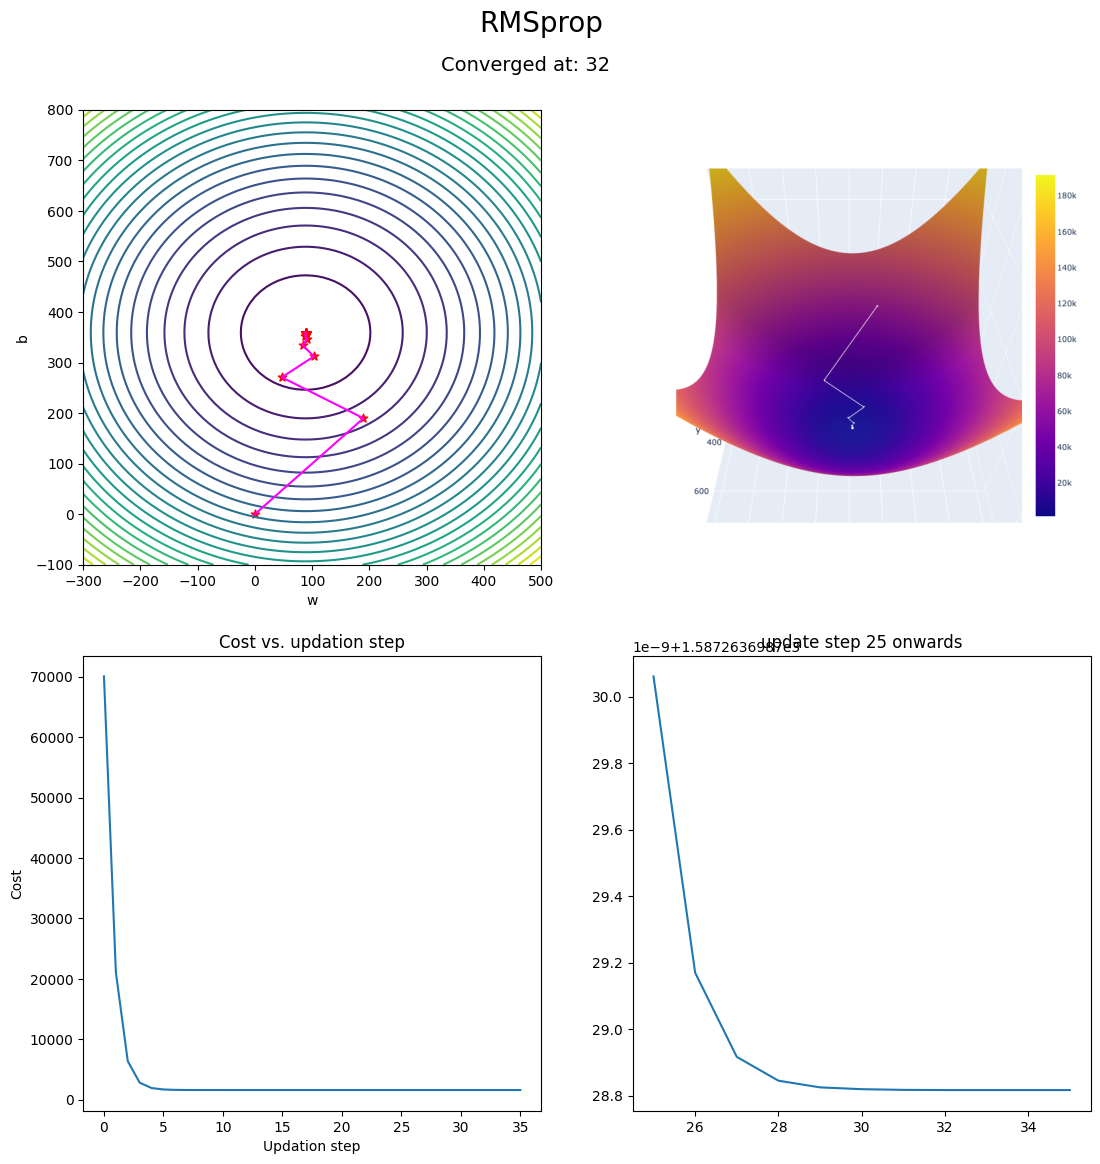

In [53]:
plot_training(model_12, (-300, 500), (-100, 800), 30, 25, "RMSprop", 0.43, 10, plotly_range="same")

## Adam (on data 2)

### model_13

In [54]:
model_13 = Model(X_raw_2, y_raw_2, 1, [80, 20, 0], -1)

Shape of X_train: (80, 1)
Shape of X_cv: (20, 1)
Shape of X_test: (0, 1)
No. of batches: 1


In [55]:
model_13.fit(alpha=10, lambda_=0, num_iters=380, 
            optimizer="Adam", hyperparameters=(0.9, 0.999, 1e-08), 
            store_hist=True, compute_test_error=False)

At epoch: 38| At updation step: 38
	 j: 2573.952242575365
	 w: [75.13102267]
	 b: 315.6773501995632
At epoch: 76| At updation step: 76
	 j: 1452.500363847046
	 w: [84.07549462]
	 b: 372.84409376465874
At epoch: 114| At updation step: 114
	 j: 1407.3816867495732
	 w: [83.28377697]
	 b: 362.0597819595635
At epoch: 152| At updation step: 152
	 j: 1406.6344294837968
	 w: [83.36284773]
	 b: 363.46407729469456
At epoch: 190| At updation step: 190
	 j: 1406.6199002675178
	 w: [83.33871813]
	 b: 363.267613265744
At epoch: 228| At updation step: 228
	 j: 1406.619578511062
	 w: [83.34109537]
	 b: 363.2962003693339
At epoch: 266| At updation step: 266
	 j: 1406.6195733791262
	 w: [83.34152098]
	 b: 363.2928525110585
At epoch: 304| At updation step: 304
	 j: 1406.6195733643501
	 w: [83.34155161]
	 b: 363.29298778684955
At epoch: 342| At updation step: 342
	 j: 1406.61957336369
	 w: [83.34155466]
	 b: 363.29303393371794
At epoch: 379| At updation step: 379
	 j: 1406.6195733636491
	 w: [83.34155546]

Converged at updation step: 336


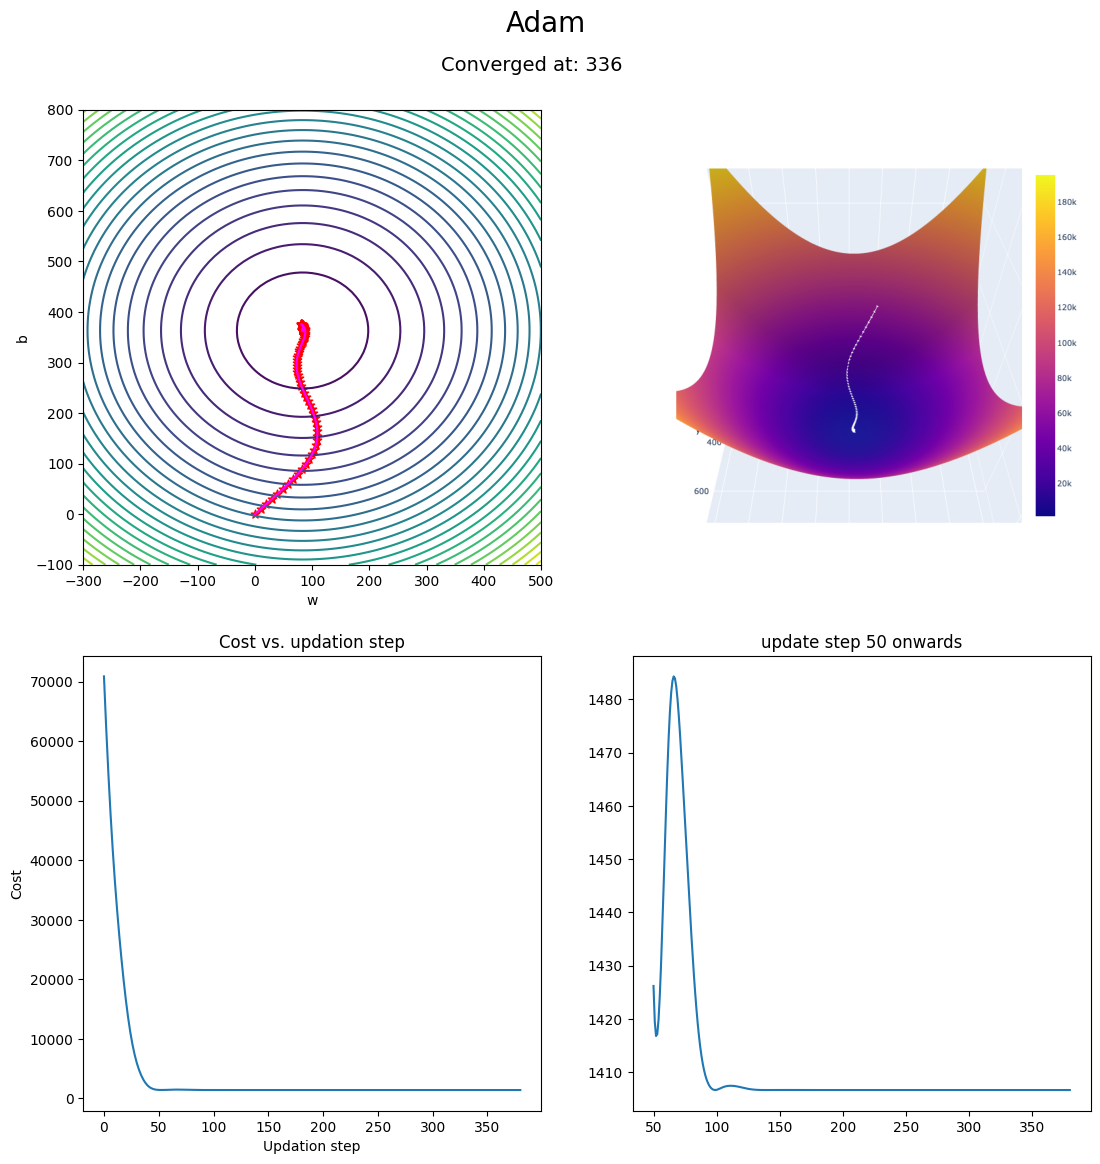

In [56]:
plot_training(model_13, (-300, 500), (-100, 800), 30, 50, "Adam", 0.45, 10, plotly_range="same")

#### NAG performs best for simple convex functions like these as it descends faster (like momentum) and also dampens the oscillations at the bottom.